In [8]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt

import pmx.solver as pmx_solver

# Define the ODE for the system

In [9]:
# ODE model
@jax.jit
def mod1(A, t, params):
    ka, cl, v1,  q, v2, kin, kout, ec50 = params["ka"], params["cl"], params["v1"], params["q"], params["v2"], params["kin"], params["kout"], params["ec50"]
    depot, center, periph, effect  = A[0], A[1], A[2], A[3]
    
    ddepot_dt = -ka * depot
    dcenter_dt = ka * depot - cl * center / v1 - q * center / v1 + q * periph / v2
    dperiph_dt = q * center / v1 - q * periph / v2
    deffect_dt = kin - kout * (1 - (center / v1) / (ec50 + center / v1)) * effect
    
    return jnp.array([ddepot_dt, dcenter_dt, dperiph_dt, deffect_dt])

# ODE model parameters
params = {"ka":0.294, "cl":18.6, "v1":40.2,   # central compartment
          "q":10.5, "v2":297,                 # peripheral compartment
          "kin": 1.0, "kout":1.0, "ec50":200} # effect compartment

# Single Dose Simulation

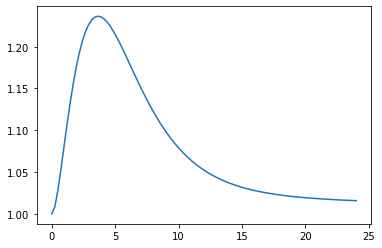

In [10]:
# Define the Initial Conditions
A0 = jnp.array([10000., 0., 0., 1.])
ts = jnp.linspace(0, 24, 100)

# Run the single dose simulation
x = pmx_solver._single_dose_solver(mod1, A0, ts, params)

# Plot the results
plt.plot(ts, x[:,3])
plt.show()

# Multiple Dose Simulation

In [11]:
# Define the Initial Conditions
A0 = jnp.array([0., 0., 0., 1.])

# Define the dosing event - 1 dose
dose = 10000.
num_doses = 10
time_start = 0
dose_interval = 12
time_step = 1
ts = jnp.arange(time_start, dose_interval+1, step=time_step).astype(float)

# Run the multiple dose simulation
obs_last, res = pmx_solver._multiple_dose_solver(model=mod1, a0=A0, t=ts, params=params, 
                                                 dose=dose, 
                                                 num_doses=num_doses)
time_points = pmx_solver.time_points(time_start=time_start, num_doses=num_doses, 
                                     dose_interval=dose_interval, time_step=time_step)[1]

# Result dataframe
res_data = pd.DataFrame(jnp.concatenate(res, axis=0), columns=["depot", "center", "periph", "effect"])
res_data["time"] = jnp.concatenate(time_points, axis=0)
res_data["center_conc"] = res_data["center"] / params["v1"]
res_data["periph_conc"] = res_data["periph"] / params["v2"]

res_data

,depot,center,periph,effect,time,center_conc,periph_conc
0,10000.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000
1,7452.765137,1783.896851,273.189392,1.084665,1.0,44.375542,0.919830
2,5554.371094,2206.294434,793.875732,1.180826,2.0,54.882946,2.672982
3,4139.543945,2086.519287,1323.578735,1.228913,3.0,51.903465,4.456494
4,3085.102539,1788.794434,1776.270752,1.234610,4.0,44.497372,5.980710
...,...,...,...,...,...,...,...
115,1315.727417,1471.684692,12637.221680,1.223056,115.0,36.609070,42.549568
116,980.579346,1264.681274,12548.187500,1.191312,116.0,31.459732,42.249790
117,730.802734,1101.737915,12414.993164,1.164523,117.0,27.406416,41.801323
118,544.650208,974.416809,12249.371094,1.142837,118.0,24.239223,41.243675


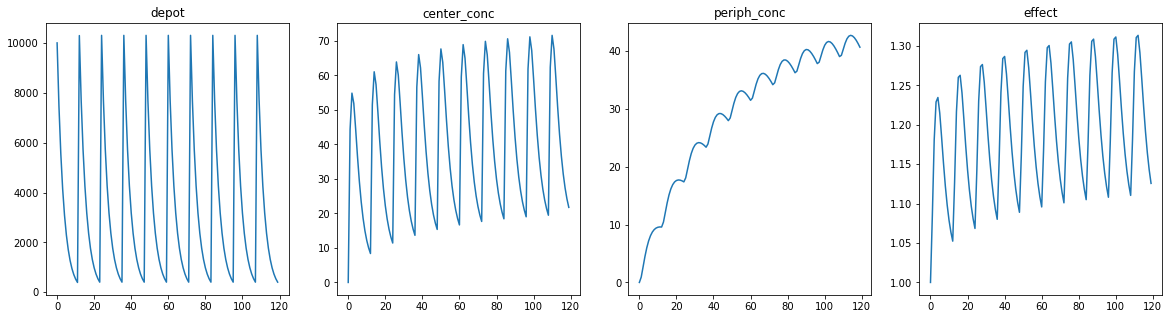

In [12]:
# Plot the results
cmpt = ["depot", "center_conc", "periph_conc", "effect"]
_, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, c in enumerate(cmpt):
    ax[i].plot(res_data["time"], res_data[c])
    ax[i].set_title(c)
plt.show()

In [13]:
# Define the Initial Conditions
A0 = jnp.array([0., 0., 0., 1.])

# Define the dosing event - 2 doses with different number of doses
dose1 = 10000.
dose2 = 2000.
num_doses1 = 10
num_doses2 = 5

dose_interval = 12
time_step = 1
time_start1 = 0
time_start2 = num_doses1 * dose_interval
ts = jnp.arange(0, dose_interval+1, step=time_step).astype(float)

# Run the multiple dose simulation
# first dose of regimen
obs_last1, res1 = pmx_solver._multiple_dose_solver(model=mod1, a0=A0, 
                                                   t=ts, params=params, 
                                                   dose=dose1, 
                                                   num_doses=num_doses1)
time_points1 = pmx_solver.time_points(time_start=time_start1, 
                                      num_doses=num_doses1, 
                                      dose_interval=dose_interval, 
                                      time_step=time_step)[1]
# second dose of regimen
obs_last2, res2 = pmx_solver._multiple_dose_solver(model=mod1, a0=obs_last1, 
                                                   t=ts, params=params, 
                                                   dose=dose2, 
                                                   num_doses=num_doses2)
time_points2 = pmx_solver.time_points(time_start=time_start2, 
                                      num_doses=num_doses2, 
                                      dose_interval=dose_interval, 
                                      time_step=time_step)[1]

# Result dataframe
res = jnp.concatenate([res1, res2], axis=0)
res_data = pd.DataFrame(jnp.concatenate(res, axis=0), 
                        columns=["depot", "center", "periph", "effect"])
time_points = jnp.concatenate([time_points1, time_points2], axis=0)
time_points = jnp.concatenate(time_points, axis=0)
res_data["time"] = time_points
res_data["center_conc"] = res_data["center"] / params["v1"]
res_data["periph_conc"] = res_data["periph"] / params["v2"]
res_data

,depot,center,periph,effect,time,center_conc,periph_conc
0,10000.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000
1,7452.765137,1783.896851,273.189392,1.084665,1.0,44.375542,0.919830
2,5554.371094,2206.294434,793.875732,1.180826,2.0,54.882946,2.672982
3,4139.543945,2086.519287,1323.578735,1.228913,3.0,51.903465,4.456494
4,3085.102539,1788.794434,1776.270752,1.234610,4.0,44.497372,5.980710
...,...,...,...,...,...,...,...
175,263.145081,445.099152,5519.730469,1.062943,175.0,11.072118,18.584951
176,196.115891,400.389832,5436.245117,1.056259,176.0,9.959946,18.303856
177,146.160477,364.563995,5345.363770,1.050649,177.0,9.068756,17.997858
178,108.930031,335.934601,5249.419434,1.046068,178.0,8.356582,17.674812


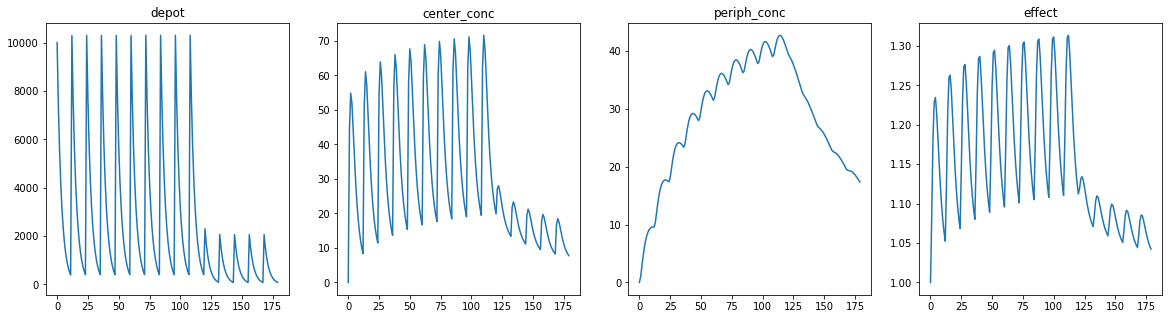

In [14]:
# Plot the results
cmpt = ["depot", "center_conc", "periph_conc", "effect"]
_, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, c in enumerate(cmpt):
    ax[i].plot(res_data["time"], res_data[c])
    ax[i].set_title(c)
plt.show()